# Fasttext - BiLSTM

# Install Lib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import nltk
nltk.download("popular")
from nltk.corpus import stopwords
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
!pip install nlp-id
!pip install transformers
from keras.preprocessing import sequence
import numpy as np
!pip install torch
!pip install tensorflow

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [3]:
!pip install textblob

# Init Data

In [4]:
from io import BytesIO

import requests
import pandas as pd

r = requests.get('https://docs.google.com/spreadsheet/ccc?key=1i3BBozbnx9HSTkMsfMHChvzYwG_2MiFB06U05gitD8U&output=xlsx')
data = r.content
#dataset = pd.read_excel('D:\Asiyah/tesis/Thesis Persuasive Detection at Paragraph-Level/All Dataset\Prepocessed (3).xlsx', dtype=str, index_col=None)
dataset = pd.read_excel(data, 'Prepocessed (3)')
dataset

<ipython-input-4-bfddf6e3e44e>:9: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  dataset = pd.read_excel(data, 'Prepocessed (3)')


,id-berita,url,judul,content per paragraf,label-positif,label-persuasif,label-produk,perspektif-tunggal,label-berita,labels,content_lower,content_punct,content_lemma,content_token,content_stopwords
0,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,Absen Online kini mulai merambah ke berbagai p...,0,0,1,1,native ads,1,absen online kini mulai merambah ke berbagai p...,absen online kini mulai merambah ke berbagai p...,absen online kini mulai rambah ke bagai usaha ...,"['absen', 'online', 'rambah', 'usaha', 'ganti'...",absen online rambah usaha ganti absen manual r...
1,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,Sebelum mengetahui manfaat absen online bagi p...,1,1,1,1,native ads,1,sebelum mengetahui manfaat absen online bagi p...,sebelum mengetahui manfaat absen online bagi p...,belum tahu manfaat absen online bagi usaha mar...,"['manfaat', 'absen', 'online', 'usaha', 'mari'...",manfaat absen online usaha mari ajar erti lapo...
2,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,Semua data tersebut selanjutnya akan diberikan...,1,0,1,1,native ads,1,semua data tersebut selanjutnya akan diberikan...,semua data tersebut selanjutnya akan diberikan...,semua data sebut lanjut akan beri kepada hrd y...,"['data', 'hrd', 'tanggung', 'gaji', 'karyawan'...",data hrd tanggung gaji karyawan data hrd rugi ...
3,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,Setiap hari karyawan melakukan absen dengan me...,1,1,0,1,native ads,1,setiap hari karyawan melakukan absen dengan me...,setiap hari karyawan melakukan absen dengan me...,tiap hari karyawan laku absen dengan tulis jam...,"['karyawan', 'laku', 'absen', 'tulis', 'jam', ...",karyawan laku absen tulis jam hadir tanda tang...
4,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,"Sementara, Absen online merupakan sistem absen...",1,1,1,1,native ads,1,"sementara, absen online merupakan sistem absen...","sementara, absen online merupakan sistem absen...",sementara absen online rupa sistem absensi yan...,"['absen', 'online', 'rupa', 'sistem', 'absensi...",absen online rupa sistem absensi manfaat jarin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,998,https://cnnindonesia.com/teknologi/20221203102...,Elon Musk Sebut Twitter Tutupi Cerita Kontrove...,Donald Trump yang menjadi lawan Biden sekaligu...,-1,0,0,1,berita murni,0,donald trump yang menjadi lawan biden sekaligu...,donald trump yang menjadi lawan biden sekalig...,donald trump yang jadi lawan biden sekaligus t...,"['donald', 'trump', 'lawan', 'biden', 'tahana'...",donald trump lawan biden tahana coba serang bi...
2498,998,https://cnnindonesia.com/teknologi/20221203102...,Elon Musk Sebut Twitter Tutupi Cerita Kontrove...,"Dalam utas tersebut, Taibbi mengatakan bahwa a...",0,0,0,1,berita murni,0,"dalam utas tersebut, taibbi mengatakan bahwa a...","dalam utas tersebut, taibbi mengatakan bahwa a...",dalam utas sebut taibbi kata bahwa apa yang ak...,"['utas', 'taibbi', 'baca', 'cuplik', 'buah', '...",utas taibbi baca cuplik buah serial dasar ribu...
2499,998,https://cnnindonesia.com/teknologi/20221203102...,Elon Musk Sebut Twitter Tutupi Cerita Kontrove...,"Namun menurut Taibbi, Twitter pelan-pelan mala...",-1,0,0,0,berita murni,0,"namun menurut taibbi, twitter pelan-pelan mala...","namun menurut taibbi, twitter pelan-pelan mala...",namun turut taibbi twitter pelan malah tambah ...,"['taibbi', 'twitter', 'pelan', 'halang', 'hala...",taibbi twitter pelan halang halang alat kontro...
2500,998,https://cnnindonesia.com/teknologi/20221203102...,Elon Musk Sebut Twitter Tutupi Cerita Kontrove...,Taibbi juga menyebut sejumlah partai politik m...,-1,0,1,1,berita murni,0,taibbi juga menyebut sejumlah partai politik m...,taibbi juga menyebut sejumlah partai po

In [5]:
len(dataset)

2502

# Split Data

In [6]:
# Misalkan menggunakan `content_lemma` sebagai input
texts = dataset['content_lemma'].values
# Variabel target y adalah kombinasi dari empat label
y = dataset['labels'].values

In [7]:
from sklearn.model_selection import KFold
#KFold(n_splits=’warn’, shuffle=False, random_state=None)
kf = KFold(5, shuffle=True, random_state=0) # Use for KFold classification

for train_index, validation_index in kf.split(texts):
  #  print("TRAIN:", texts[train_index], "VALIDATION:", texts[validation_index])
   X_train, X_test = texts[train_index], texts[validation_index]
   y_train, y_test = y[train_index], y[validation_index]

In [8]:
#Y = dataset['labels']
#X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2002,) (2002,)
(500,) (500,)


In [9]:
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

# Word Embedding Fasttext

In [10]:
import os
# Install Gensim
!pip install --upgrade gensim
!pip install fasttext
# Download dan unzip dataset
wrdvec_path = 'cc.id.300.bin.gz'
#if not os.path.exists(wrdvec_path):
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.4-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.4-py3-none-any.whl (240 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246492 sha256=000b51ba8d68431c001a9eae085644703425bcf08a26495fa25727ec62e61a14
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext
--2024-08-20 12:21:54--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.15, 13.226.210.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
max_fatures = 100000
#Tensorflow Tokenizer
tokenizer = Tokenizer(num_words=max_fatures,split=' ')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.index_word)+1
vocab_size

10288

In [13]:
# Convert text to sequence of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [14]:
# Padding
max_length = 257  # asumsi maksimal panjang sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [15]:
print(X_train_pad.shape)
print(X_test_pad.shape)

(2002, 257)
(500, 257)


In [16]:
from textblob import Word
num_tokens = len(tokenizer.index_word)+1

def get_weights(embedding_vectors,embedding_dim):
    global num_tokens,tokenizer

    # assign vectors to words using the pretrained model embedding_vectors
    embedding_weights = np.zeros((num_tokens,embedding_dim))

    # count how many words are not assigned with the pretrained model.
    # By default, vectors associated to words are zero vectors.
    misses = 0

    # the index in word_index starts with 1
    for word, i in tokenizer.word_index.items():
        vector = embedding_vectors.get(word)
        # the word_index is ordered by word frequency
        if i>=num_tokens :
            break
        elif vector is not None:
            embedding_weights[i] = vector
        else:
            if len(word)<20:
                word = Word(word)
                word = word.spellcheck()[0][0]
                vector = embedding_vectors.get(str(word))
                if vector is not None:
                    embedding_weights[i] = vector
                else:
                    misses +=1
                    #print(word)
            else:
                misses +=1
                #print(word)

    print(f"The number of missed words is {misses}")

    return embedding_weights

In [17]:
import os
path = r"/content/drive/MyDrive/Pre-trained Embeddings/cc.id.300.vec"
print(os.path.exists(path))

True


In [18]:
embedding_vectors_fasttext = {}
with open("/content/drive/MyDrive/Pre-trained Embeddings/cc.id.300.vec","r", encoding='utf-8') as file:
    file.readline()
    for line in file:
        word , vector = line.split(maxsplit=1)
        vector = np.fromstring(vector,"float32",sep=" ")
        embedding_vectors_fasttext[word] = vector

In [19]:
# assign vectors to words using the pretrained model fasttext
embedding_matrix = get_weights(embedding_vectors_fasttext, embedding_dim=300)

The number of missed words is 695


## Saved Embedding Model

In [20]:
# Step 1: Menyimpan embedding matrix
filename_npy = '/content/drive/MyDrive/Colab Notebooks/Thesis Persuasive Detection at Paragraph-Level  /Embedding Models/FS_embedding.npy'
# Simpan embedding matrix ke dalam file .npy
np.save(filename_npy, embedding_matrix)

print(f"Embedding matrix saved to {filename_npy}")

Embedding matrix saved to /content/drive/MyDrive/Colab Notebooks/Thesis Persuasive Detection at Paragraph-Level  /Embedding Models/FS_embedding.npy


#Split Word Embedding to Training-Testing

In [21]:
# # Convert training and testing data to vectors using the word embeddings
# X_train_ft = get_weights(X_train, embedding_matrix)  # Replace with your actual conversion function
# X_test_ft = get_weights(X_test, embedding_matrix)


# BiLSTM

In [22]:
from keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D,concatenate,ConvLSTM1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [23]:
tf.keras.backend.clear_session()

embed_dim = 300
vocab_size = len(tokenizer.index_word)+1
model = Sequential()
## embedding layer

model = Sequential([
    # Lapisan embedding yang mengonversi input integer menjadi vektor dense
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=257, weights=[embedding_matrix], trainable=False),
    BatchNormalization(),
    Dropout(0.2),  # Tambahkan Dropout
    # Lapisan BiLSTM
    Bidirectional(LSTM(256, return_sequences=True)),
    GlobalMaxPooling1D(),  # Tambahkan GlobalMaxPooling1D
    # Opsional: Tambahkan dropout untuk regularisasi
    Dropout(0.2),
    # Lapisan Dense untuk klasifikasi
    Dense(2, activation='sigmoid')  # '4' sesuai dengan jumlah label target Anda, sesuaikan jika berbeda
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
model.build(input_shape=(None, 257))
# Ringkasan model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 257, 300)            │       3,086,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 257, 300)            │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 257, 300)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 257, 512)            │       1,140,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,229,362 (16.13 MB)

 Trainable params: 1,142,362 (4.36 MB)

 Non-trainable params: 3,087,000 (11.78 MB)

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Gunakan 'sparse_categorical_crossentropy' jika label adalah integer
              metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, epochs=50, batch_size=128, validation_data=(X_test_pad, y_test))
score = model.evaluate(X_test_pad, y_test, verbose=0)
print("Accuracy: {:.2f}%".format(score[1] * 100))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.7301 - loss: 0.5269 - val_accuracy: 0.7780 - val_loss: 0.4421
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8944 - loss: 0.2607 - val_accuracy: 0.9060 - val_loss: 0.3230
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9231 - loss: 0.1995 - val_accuracy: 0.8960 - val_loss: 0.3201
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9362 - loss: 0.1633 - val_accuracy: 0.4640 - val_loss: 0.8081
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9583 - loss: 0.1305 - val_accuracy: 0.8200 - val_loss: 0.4944
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9618 - loss: 0.1061 - val_accuracy: 0.8920 - val_loss: 0.4299
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9762 - loss: 0.0787 - val_accuracy: 0.8220 - val_loss: 0.4038
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9802 - loss: 0.0525 - val_accuracy: 0

## Get Evaluate Score

In [26]:
yhat = model.predict(X_test_pad, verbose=0)
classes_x=np.rint(yhat)

In [27]:
npa = np.array(y_test)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support as score

precision,recall,fscore,support=score(npa,classes_x,average='macro')
print('Precision : ',format(precision))
print('Recall    : ',format(recall))
print('F-score   : ',format(fscore))
print('Accuracy : ',accuracy_score(npa, classes_x))

Precision :  0.928871668992957
Recall    :  0.9310500515995872
F-score   :  0.9296553110240177
Accuracy :  0.93


In [29]:
from sklearn.metrics import classification_report

print(classification_report(npa, classes_x))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       228
           1       0.95      0.92      0.93       272

   micro avg       0.93      0.93      0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500
 samples avg       0.93      0.93      0.93       500



In [30]:
npa = np.argmax(npa, axis=-1)
classes_x = np.argmax(classes_x, axis=-1)

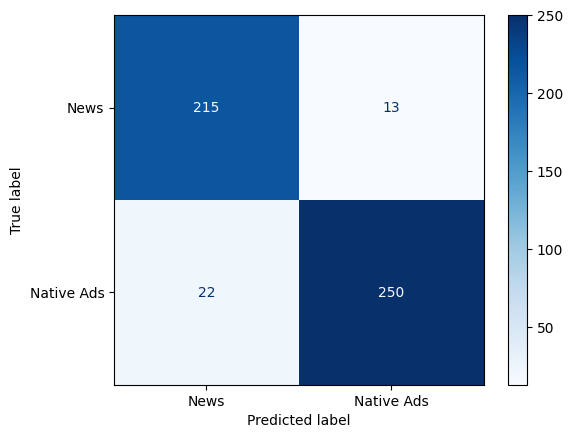

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ["News", "Native Ads"]

cm = confusion_matrix(npa, classes_x)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## roc

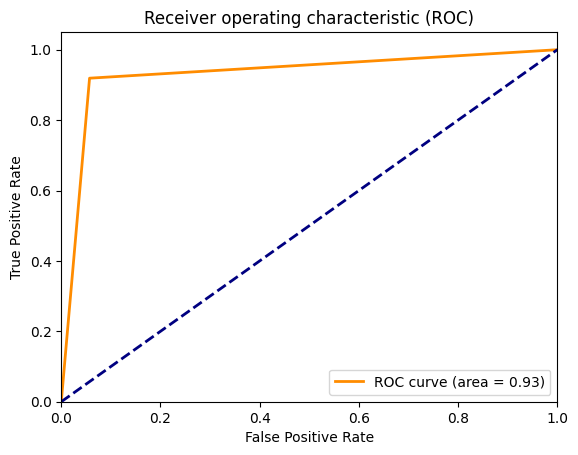

In [32]:
import numpy as np
from sklearn import metrics

y = np.array(npa)

scores = np.array(classes_x)
fpr, tpr, thresholds = metrics.roc_curve(npa, classes_x)
roc_auc = metrics.auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [33]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, thresholds_rf = roc_curve(npa, classes_x)
auc_rf = auc(fpr_rf, tpr_rf)

In [34]:
auc_rf

0.9310500515995871

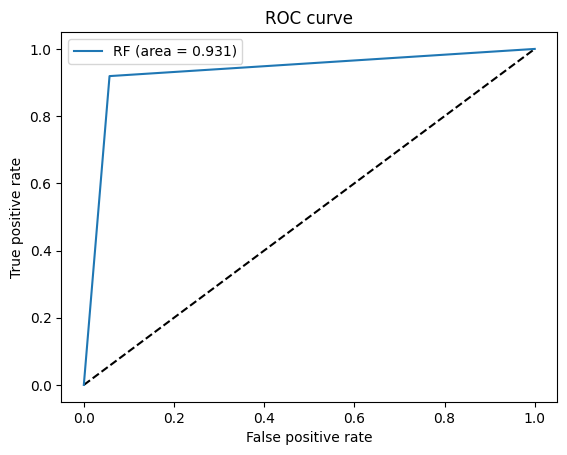

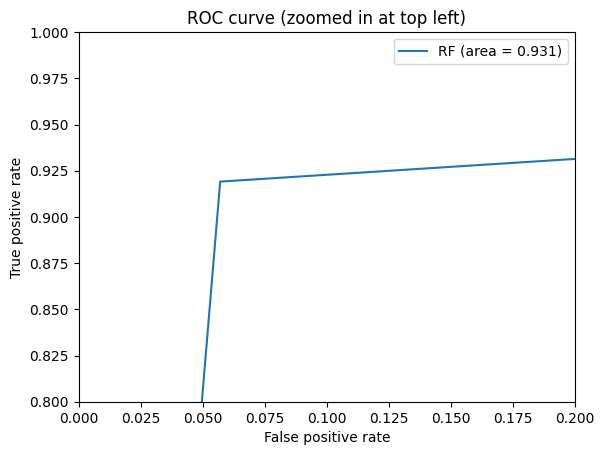

In [35]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [36]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr,tpr)
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

In [37]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve ( npa , classes_x)

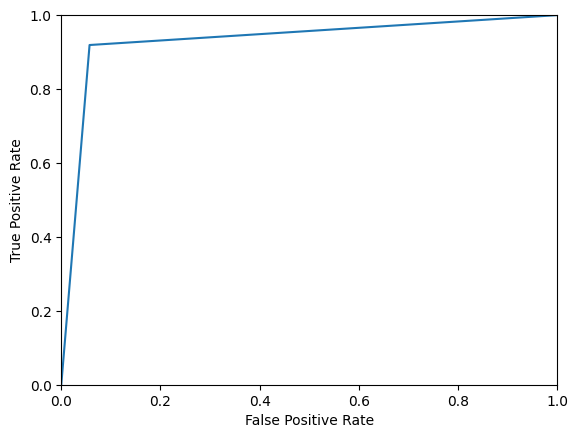

In [38]:
plot_roc_curve (fpr,tpr)

In [39]:
roc_auc_score(npa,classes_x)

0.9310500515995871

0.9310500515995871


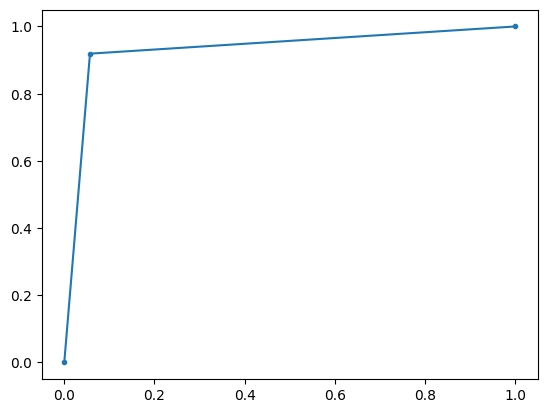

In [40]:
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(npa, classes_x)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
print(auc_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [41]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [42]:
perf_measure(npa,classes_x)

(250, 13, 215, 22)

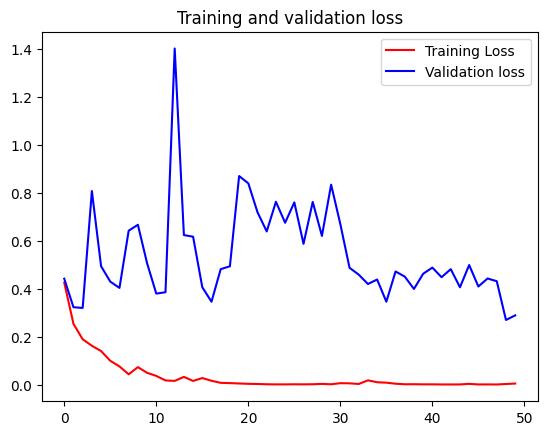

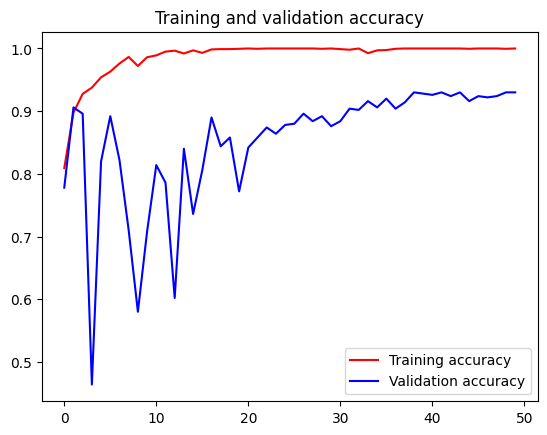

<Figure size 640x480 with 0 Axes>

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()




plt.show()